# Performance énergétique des logements et niveau de vie des ménages en Ile-de-France¶

#### **Projet Python 2A ENSAE (année 2022-2023)**

#### Franki Nguimatsia Tiofak, Marc jodel Simo Noubissi, Gabriel Sklénard

## **Introduction**

### **Problématique:** 
 
Dans le contexte de la crise énergétique affectant un grand nombre de pays en 2022, il nous est apparu particulièrement intéressant d'étudier le lien entre performance énergétique des logements et niveau de vie des ménages. En effet, dans une période où la facture énergétique s'alourdit et atteint même des plus haut (en particulier pour le gaz), les ménages les plus défavorisés apparaissent plus vulnérables, et ce d'autant plus si leurs logements sont en moyenne plus énergivores que les ménages plus aisés. Notre projet Python cherche précisément à documenter cette vulnérabilité, avec notamment l'idée que la performance énergétique des logements ont un coût et bute nécessairement contre la contrainte budgétaire des ménages, mesurée ici par le niveau de vie médian au niveau de la commune. Qui plus est, un cercle vicieux pourrait s'instaurer: les ménages les moins aisés ont des difficultés à accéder à un logement économe en énergie, ce qui accroît la charge financière du logement et les appauvrit encore davantage. 

Pour avoir une volumétrie de données raisonnable, nous avons opté pour une approche géographique centrée sur l'Ile-de-France: il s'agit donc ici d'analyser la performance énergétique des logements franciliens en lien avec le niveau de vie mesuré dans chaque commune. La visualisation géographique pourrait contribuer à aider les décideurs publics à mieux cibler les éventuelles mesures de soutien à mettre en place pour atténuer le choc de la crise énergétique en Ile-de-France.

### **Principales étapes du projet:**
1. Récupération des données relatives aux diagnostics de performance énergétique (DPE) des logements franciliens (à partir de l'API de l'open data de l'ADEME.
2. Récupération des données de niveau de vie par commune à partir des fichiers de Filosofi 2016 disponibles sur Insee.fr
3. Retraitement des données.
4. Premières statistiques descriptives
5. Visualisations géographiques
6. Modélisation pour prédir: 
    a. la proportion de logements énergivores d'une commune en Ile-de-France; 
    b. le niveau médian de consommation d'énergie d'un logement d'une commune en Ile-de-France;
7. Principales limites et perspectives d'approfondissment

### **Principaux résultats et principales limites:**

#### Résulats de l'étude

1. Résultat 1: 
2. Résultat 2:
3. Résultat 3:

#### Limites de l'étude

1. Limite 1: les DPE observés dans chaque commune d'Ile-de-France ne résultent pas d'un échantillonage reposant sur un
plal de sondage garantissant la représentativité statistique des données à l'échelle de chaque commune. On ne dispose
en effet que d'une liste de DPE versés automatiquement dans la base de données de l'ADEME, dès lors qu'un diagnostic est validé numériquement. Par conséquent, on peut très bien imaginer que nos résultats sont affectés par des biais statistiques importants. Le nombre de DPE enregistrés dans une commune dépend du nombre de locations ou ventes de logements ayant eu lieu dans cette commune.
2. Limite 2: la maille géographique "commune" reste assez grossière pour bien localiser les zones de vulnérabilité socio-économique, et d'autant plus en Ile-de-France, une région très contrastée où il y a souvent coexistence de types de ménages très différents d'une rue à une autre.
3. Limite 3:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly
import re
import matplotlib
import plotly.express as px
import seaborn as sns

import sklearn
from sklearn.linear_model import Lasso
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import statsmodels.api as sm
import scipy
from scipy.stats import chi2_contingency as chi2_contingency
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

from plotly.offline import init_notebook_mode
init_notebook_mode(connected = True)

import plotly
import plotly.express as px
from IPython.display import HTML #pour afficher les graphs
# dans une cellule de notebook

In [3]:
# Pour que les graphiques apparaissent dans le Notebook Jupyter:
%matplotlib inline

## **Importation des données retraitées**

In [4]:
pd.options.display.max_colwidth = 50

On importe les données récupérées et traitées dans le notebook récup&retraitement_données.ipynb:

In [5]:
# 1) Dataframe rassemblant tous les dpe réalisés dans les communes d'Ile-de-France (principales caractéristiques relatives 
# à la performance énergétique des logements):
# WARNING: pour lire ce csv, pensez à exécuter au préalable le notebook récup&retraitement_données.ipynb
# en effet le fichier dpe_IDF.csv est trop volumineux pour être stocké dans le repository Github "data_science_project"!
#dpe_idf = pd.read_csv("~/work/data_science_project/dpe_IDF.csv")

# 2) Dataframe rassemblant les communes d'IDF avec leur caractéristiques en terme de performance énergétique des logements
# ainsi que quelques données socio-économiques (Filosofi):
Filosofi_dpe_IDF_com= pd.read_csv("~/work/data_science_project/Filosofi_dpe_IDF_com.csv")

## **I) Datavisualisation**

### **A) Statistiques descriptives sur la performance énergétique des logements à l'échelle des communes d'Ile-de-France:**

#### 1) Etape préliminaire: on exclut de l'analyse les communes pour lesquelles le nombre de DPE s'avère trop faible au regard du nombre de ménages fiscaux renseignés dans Filosofi:

L'interprétabilité des résultats est conditionnée par le fait que l'on dispose d'un nombre suffisant de DPE dans chaque commune. Pour tester cette condition, on calcule le ratio "nombre de DPE/nombre de ménages fiscaux" pour chaque commune, avec l'idée que le nombre de ménages fiscaux est un bon proxi du nombre total de logements dans une commune donnée.

In [6]:
# Calcul du ratio "nombre de DPE/nombre de ménages fiscaux":
Filosofi_dpe_IDF_com["ratio_DPE_menage"]=Filosofi_dpe_IDF_com["nombre_dpe"]/Filosofi_dpe_IDF_com["NBMENFISC16"]
Filosofi_dpe_IDF_com["ratio_DPE_menage"].describe()

count    1013.000000
mean        0.327655
std         0.686188
min         0.007556
25%         0.097826
50%         0.181564
75%         0.312899
max        11.027027
Name: ratio_DPE_menage, dtype: float64

Pour chaque commune, nous disposons en moyenne d'un nombre de DPE représentant près de 33% du nombre total de logements de la commune. Mais il y a de l'hétérogénéité.

Au vue de la distribution de ce ratio, on peut décider d'exclure de l'analyse les communes qui présentent un nombre de DPE inférieur à 5% du nombre de ménages fiscaux déclarés dans cette commune:

In [7]:
Filosofi_dpe_IDF_com2=Filosofi_dpe_IDF_com[Filosofi_dpe_IDF_com["ratio_DPE_menage"]>0.05].reset_index()
Filosofi_dpe_IDF_com2.shape

(961, 53)

In [8]:
Filosofi_dpe_IDF_com.shape

(1288, 52)

On a donc exclu de l'analyse 327 communes, pour lesquelles le nombre de dpe disponibles dans la base était trop faible au regard du nombre de ménages fiscaux.

#### 2) Création de variables supplémentaires pour les besoins de l'analyse

##### a) Création d'une indicatrice pour repérer les communes avec une proportion élevée de logements énergivores

Nous disposons pour chaque commune de la répartition des logements diagnostiqués selon leur catégorie de consommation énergétique (des plus économes en énergie A aux plus énergivores G). Notre analyse se focalisera en grande partie sur la répartition géographique des logements énergivores en Ile-de-France ainsi que sur les variables suceptibles d'expliquer qu'une commune présente une proportion plus ou moins élevée de logements énergivores. En accord avec les conventions de l'ADEME, nous qualifierons d'énergivores les logements dont la classe de consommation énergétique est F ou G.

Dans ce qui suit, nous commençons par créer une variable donnant la proportion de logements diagnostiqués classés en F ou G (dits "énergivores"):

In [9]:
# 1) Codage de la variable "proportions de logements énergivores":
Filosofi_dpe_IDF_com2["proportion_energivores"]=Filosofi_dpe_IDF_com2.loc[:,['classe_consommation_energie_F','classe_consommation_energie_G']].sum(axis=1)

Filosofi_dpe_IDF_com2["proportion_energivores"].describe()


count    961.000000
mean       0.146092
std        0.096875
min        0.000000
25%        0.086957
50%        0.129032
75%        0.192623
max        0.750000
Name: proportion_energivores, dtype: float64

En moyenne, pour les communes d'Ile-de-France qui ont bénéficié d'un dpe, 14,6% des logements sont classés "énergivores". Par ailleurs, un quart des communes présentent une part de logements énergivores inférieure à 8,7% et un autre quart une part supérieure à 19,3%. 

On peut vérifier rapidement que les proportions élevées ne sont pas liées au fait que le nombre de dpe réalisés dans la commune est faible:

Text(0.5, 1.0, "Proportion de logements énergivores dans les communes d'Ile-de-France et nombre de DPE réalisés")

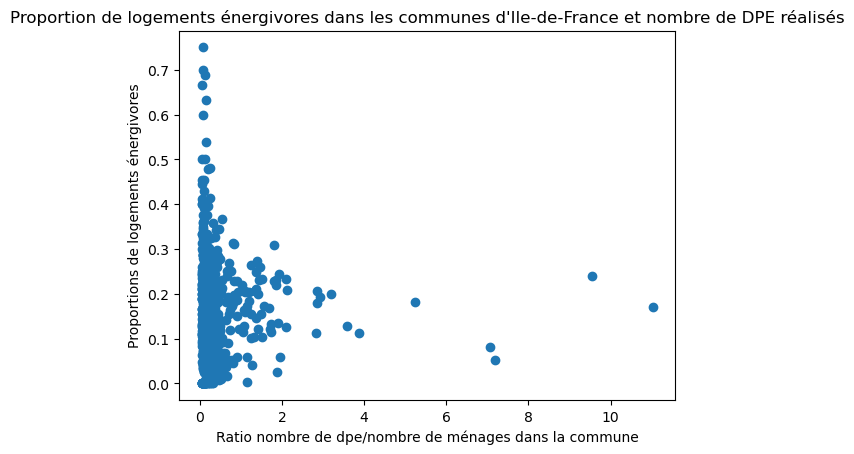

In [10]:

plt.figure()
plt.scatter(Filosofi_dpe_IDF_com2["ratio_DPE_menage"],Filosofi_dpe_IDF_com2["proportion_energivores"])
plt.xlabel("Ratio nombre de dpe/nombre de ménages dans la commune")
plt.ylabel("Proportions de logements énergivores")
plt.title("Proportion de logements énergivores dans les communes d'Ile-de-France et nombre de DPE réalisés")

On peut voir que pour les quelques communes présentant une forte proportion de logements énergivores (>0,5), le ratio nombre de dpe/nombre de ménages est proche de zéro. Dans ces communes, le fait qu'une majorité de logements serait énergivore s'expliquerait donc plutôt par le fait que peu de diagnostics dpe y ont été réalisés au regard du nombre total de logements. Il ne faudra donc pas surinterpréter ces proportions très élevées de logements énergivores dans l'analyse qui va suivre. 

Pour rappel, le nombre de DPE enregistrés n'est en aucun cas le résultat d'un échantillonage, mais ne résulte que des réalisations de locations/ventes de logements privatifs depuis 2013 ayant fait l'objet d'un DPE.

Afin de mieux repérer les communes présentant une proportion "élevée" de logements énergivores, on code l'indicatrice suivante:

In [11]:
# Codage de l'indicatrice permettant de repérer les communes présentant plus de 20% des logements diagnostiqués "énergivores":
Filosofi_dpe_IDF_com2['com_prop_energivores'] =pd.cut(Filosofi_dpe_IDF_com2['proportion_energivores'],\
                                                      bins=[Filosofi_dpe_IDF_com2['proportion_energivores'].min(),
                                                            0.2,Filosofi_dpe_IDF_com2['proportion_energivores'].max()],\
                                                          labels=["Moins de 20%",
                                                                  "Plus de 20%"],include_lowest=True)
Filosofi_dpe_IDF_com2['com_prop_energivores'].value_counts()

Moins de 20%    751
Plus de 20%     210
Name: com_prop_energivores, dtype: int64

##### b) Création d'une variable catégorielle relative aux tailles des communes selon leur nombre d'habitants

Pour l'analyse, il sera intéressant de distinguer les communes selon leur taille (nombre d'habitants).

In [12]:
# Classes de taille de commune basées sur le nombre de personnes vivant dans les ménages fiscaux en 2016: 
Filosofi_dpe_IDF_com2['classe_taille_com'] = pd.cut(Filosofi_dpe_IDF_com2['NBPERSMENFISC16'],bins=[Filosofi_dpe_IDF_com2['NBPERSMENFISC16'].min(),
                                                            200,10000,Filosofi_dpe_IDF_com2['NBPERSMENFISC16'].max()],\
                                                          labels=["Moins de 200 hab.",
                                                                  "Entre 200 et 10 000 hab.",
                                              "Plus de 10 000 hab."],\
                                     include_lowest=True)
Filosofi_dpe_IDF_com2['classe_taille_com'].value_counts()

Entre 200 et 10 000 hab.    688
Plus de 10 000 hab.         233
Moins de 200 hab.            40
Name: classe_taille_com, dtype: int64

#### 3) Premières statistiques descriptives uni et bi-variées sur les variables quantitatives et qualitatives de la base Filosofi_dpe_IDF_com:

##### a) Indicateurs statistiques élémentaires (moyenne, variance et quartiles) sur les variables quantitatives:

In [13]:
Filosofi_dpe_IDF_com3=Filosofi_dpe_IDF_com2.loc[:,~Filosofi_dpe_IDF_com2.columns.isin(["index","CODGEO","LIBGEO","DEP","code_insee_commune_actualise","MED16_quintiles"
                                                                                      "com_prop_energivores","classe_taille_com"])]
round(Filosofi_dpe_IDF_com3.describe(), 3)

,NBMENFISC16,NBPERSMENFISC16,MED16,consommation_energie,estimation_ges,surface_thermique_lot,age_logement,classe_consommation_energie_A,classe_consommation_energie_B,classe_consommation_energie_C,...,estimation_ges_quintiles_Q3,estimation_ges_quintiles_Q4,estimation_ges_quintiles_Q5,surface_thermique_lot_median,age_logement_median,consommation_energie_median,estimation_ges_median,nombre_dpe,ratio_DPE_menage,proportion_energivores
count,961.000,961.000,961.000,961.000,961.000,961.000,961.000,961.000,961.000,961.000,...,961.000,961.000,961.000,961.000,961.000,961.000,961.000,961.000,961.000,961.000
mean,4475.561,10844.998,24560.723,215.250,27.387,222.697,67.970,0.078,0.174,0.097,...,0.188,0.191,0.201,90.821,33.428,193.495,18.421,1008.576,0.343,0.146
std,10557.227,23381.065,3839.718,111.221,24.209,2847.258,74.009,0.087,0.158,0.070,...,0.112,0.102,0.118,63.626,21.582,62.381,9.233,1770.075,0.701,0.097
min,37.000,100.000,13025.769,17.895,0.632,22.402,0.938,0.000,0.000,0.000,...,0.000,0.000,0.000,17.900,0.000,0.000,0.000,3.000,0.051,0.000
25%,228.000,610.000,22407.273,177.413,20.832,98.305,31.178,0.019,0.044,0.058,...,0.116,0.126,0.118,68.600,20.000,165.000,12.990,31.000,0.107,0.087
50%,654.000,1693.000,24496.000,214.761,26.340,110.973,45.767,0.054,0.134,0.088,...,0.167,0.186,0.192,90.000,37.000,207.500,16.080,175.000,0.193,0.129
75%,3546.000,9382.500,26681.333,243.778,31.652,127.172,74.045,0.111,0.261,0.125,...,0.238,0.250,0.270,104.190,43.000,229.970,22.000,1160.000,0.322,0.193
max,111969.000,216315.000,43848.667,3158.066,723.206,88308.130,764.245,0.895,0.798,0.545,...,0.683,0.660,0.767,1850.800,380.000,469.400,72.520,9191.000,11.027,0.750


##### b) Répartition des communes présentant une proportion élevée de logements diagnostoqués énergivores

<AxesSubplot: title={'center': "Répartition des communes selon leur département d'appartenance"}, xlabel='DEP'>

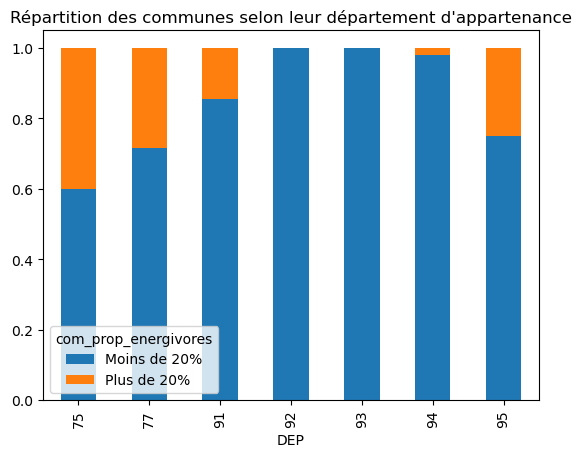

In [14]:
pd.crosstab(Filosofi_dpe_IDF_com2["DEP"],Filosofi_dpe_IDF_com2["com_prop_energivores"],\
            normalize='index').plot.bar(stacked=True,title="Répartition des communes selon leur département d'appartenance")

On peut remarquer que c'est à Paris que l'on trouve la plus forte proportion de communes (en l'occurrence il s'agit ici des 20 arrondissements) affichant plus de 20% de logements diagostiqués énergivores. On peut imaginer que la dimension historique d'une partie importante des logements parisiens (immeubles haussmaniens) peut contribuer à ce résultat. 

A contrario, les départements du 92, 93 ou du 94 ne présentent  presque pas de communes avec plus de 20% de logements diagnostiqués F ou G. On peut intuiter que cela pourrait refléter que ces départements possèdent un parc immobilier beaucoup plus récent (ces départements se sont urbanisés durant la deuxième moitié du XXème siècle, avec des normes énergétiques plus exigeantes que celles qui avaient cours au XIXe siècle avec Haussmann!).

<AxesSubplot: title={'center': 'Répartition des communes selon leur taille'}, xlabel='classe_taille_com'>

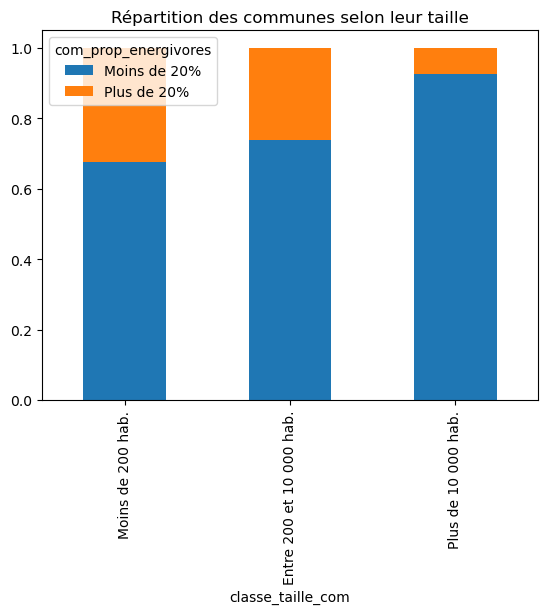

In [15]:
pd.crosstab(Filosofi_dpe_IDF_com2["classe_taille_com"],Filosofi_dpe_IDF_com2["com_prop_energivores"],\
            normalize='index').plot.bar(stacked=True,title="Répartition des communes selon leur taille")

En moyenne, il apparaît que plus la commune est de grande taille, plus la part de communes avec plus de 20% de logements énergivores est faible. Il semble que les catégories F et G concernent davantage des petites communes, souvent en milieu plus rural.

<AxesSubplot: title={'center': 'Répartition des communes selon leur niveau de vie'}, xlabel='Niveau de vie médian (quintiles)'>

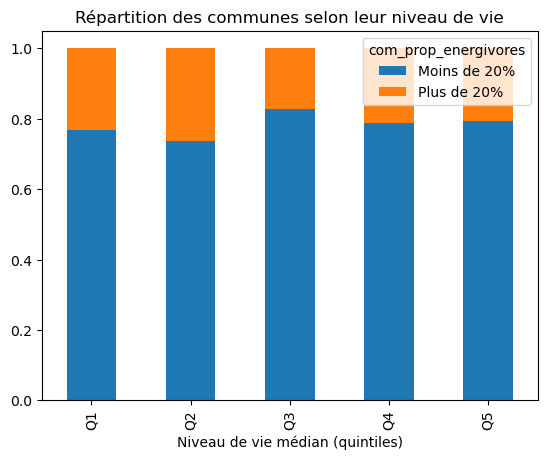

In [16]:
pd.crosstab(Filosofi_dpe_IDF_com2["MED16_quintiles"],Filosofi_dpe_IDF_com2["com_prop_energivores"],\
            normalize='index').plot.bar(stacked=True,title="Répartition des communes selon leur niveau de vie",\
                                       xlabel="Niveau de vie médian (quintiles)")

A première vue, il ne semble pas qu'il y ait un lien très net entre le niveau de vie de la commune et la forte proportion de logements énergivores dans cette commune. Certes, on peut voir que dans les communes les plus défavorisés (Q1 et Q2 du niveau de vie) la proportion de communes présentant plus de 20% de logements énergivores est légèrement plus élevée que dans les quintiles de niveau de vie supérieurs, mais la différence reste assez légère.

##### c) Distribution de la proportion de logements énergivores dans les communes d'Ile-de-France en fonction de différentes variables catégorielles caractéristiques des communes

In [17]:
Filosofi_dpe_IDF_com2["proportion_energivores_pct"]=Filosofi_dpe_IDF_com2["proportion_energivores"].apply(lambda x: x*100)

**Distribution selon le département de la commune**

Text(0.5, 0, 'Département')

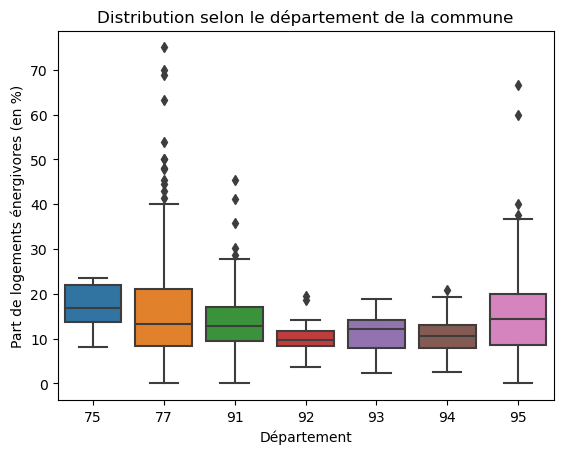

In [18]:
# Distribution selon le département:

sns.boxplot(data=Filosofi_dpe_IDF_com2,y="proportion_energivores_pct",x="DEP")
plt.title("Distribution selon le département de la commune")
plt.ylabel("Part de logements énergivores (en %)")
plt.xlabel("Département")

Dans les départements 75, 92, 93 et 94, il ressort que l'hétérogénéité entre les communes est relativement faible en termes de proportion de logements énergivores: les écarts inter-quartiles sont particulièrement faibles. Mais tandis que les départements 92, 93 et 94 affichent les Q3 et les Q2 les plus faibles d'Ile-de-France, le 75 se distingue par des quantiles élevés (attention: il y a peu de communes dans le 75, donc les quantiles n'ont pas forcément beaucoup de sens!).

A contrario, la dispersion des proportions de logements énergivores est beaucoup plus prononcée dans les départements 77, 95 et 91. Il s'agit peut-être de départements moins urbanisés, avec un mélange de zones rurales et de zones urbaines, et donc des types de constructions plus hétérogènes...?

**Distribution selon la taille de la commune**

Text(0.5, 0, 'Taille des communes')

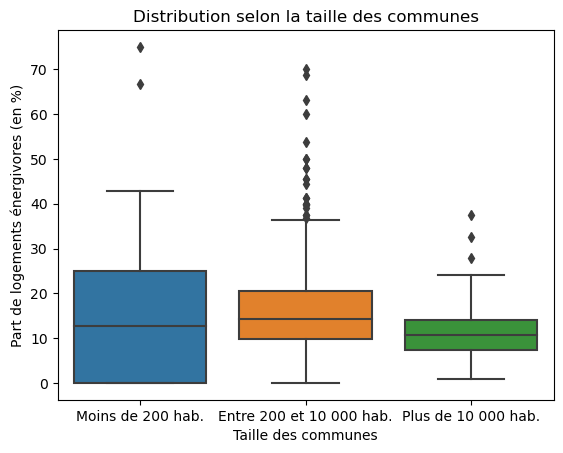

In [19]:
# Distribution selon la taille des communes:

sns.boxplot(data=Filosofi_dpe_IDF_com2,y="proportion_energivores_pct",x="classe_taille_com")
plt.title("Distribution selon la taille des communes")
plt.ylabel("Part de logements énergivores (en %)")
plt.xlabel("Taille des communes")

Tout d'abord, comme il n'y a que 40 communes de moins de 200 habitants dans notre base, le premier boxplot bleu n'est pas très interprétable et comparable avec les deux autres catégories. Lorsque l'on compare, les petites communes (entre 200 et 10 000 habitants) et les grandes communes (>10 000 habitants), on remarque que les quartiles Q1, Q2 et Q3 sont plus faibles lorsque la commune est de grande taille. On peut penser que les logements y sont plus récents et plus de type "appartements" que "maisons".

**Distribution selon le niveau de vie médian de la commune**

Text(0.5, 0, 'Niveau de vie médian dans les communes')

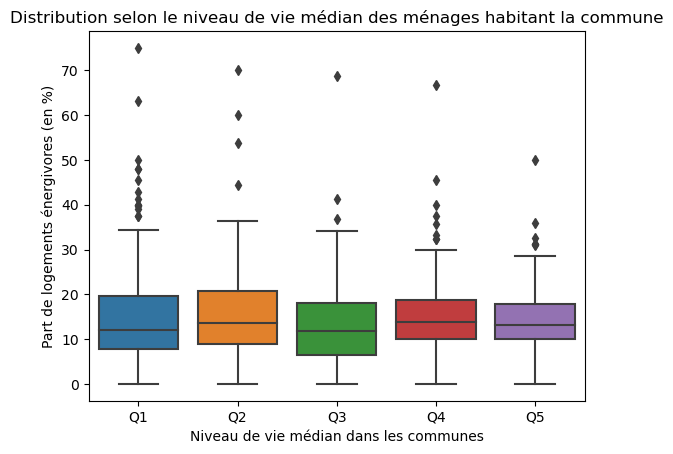

In [20]:
# Distribution selon le niveau de vie des communes:

sns.boxplot(data=Filosofi_dpe_IDF_com2,y="proportion_energivores_pct",x="MED16_quintiles",order=["Q1","Q2","Q3","Q4","Q5"])
plt.title("Distribution selon le niveau de vie médian des ménages habitant la commune")
plt.ylabel("Part de logements énergivores (en %)")
plt.xlabel("Niveau de vie médian dans les communes")

Encore une fois, nous constatons que la distribution de la part des logements énergivores varie peu selon les quintiles de niveau de vie médian. Par exemple, parmi les 20% des communes les plus défavorisées, il y a la moitié de ces communes avec peu plus de 12% de logements énergivores. Et il en va de même pour les 20% des communes les plus favorisées. On peut penser que l'Ile-de-France est un peu une région atypique, au sens où l'on trouve en milieu urbain à la fois des ménages très aisés dans des logements très anciens (du type "beaux quartier haussmaniens parisien") et à la fois dans des logements neufs ou récents dans certaines banlieues chics du 92 (du type "éco-quartier d'Issy-les-Moulineaux). Et de même, les plus populations défavorisées sont massivement dans des logements sociaux, qui peuvent être plus ou moins récents et mis aux normes énergétiques actuelles.

Il faut également penser au fait que l'information sur le niveau de vie n'est pas disponible avec la même granularité que celle sur la performance énergétique des logements d'une commune. En effet, le niveau de vie n'est donné qu'au niveau de la commune. Or il y a de l'hétérogénéité au sein d'une commune, selon les quartiers ou même parfois les rues. Dans l'idéal, il faudrait regarder le lien entre proportion de logements énergovores et niveau de vie à une maille géographique beaucoup plus fine (du type données carroyées de Filosofi).

#### 3) Quelles corrélations statistiques entre les différentes variables quantitatives de la base?

##### a) Matrice de corrélation des principales variables quantitatives disponibles au niveau communal dans la base

Text(0.5, 1.0, 'Matrice de corrélation')

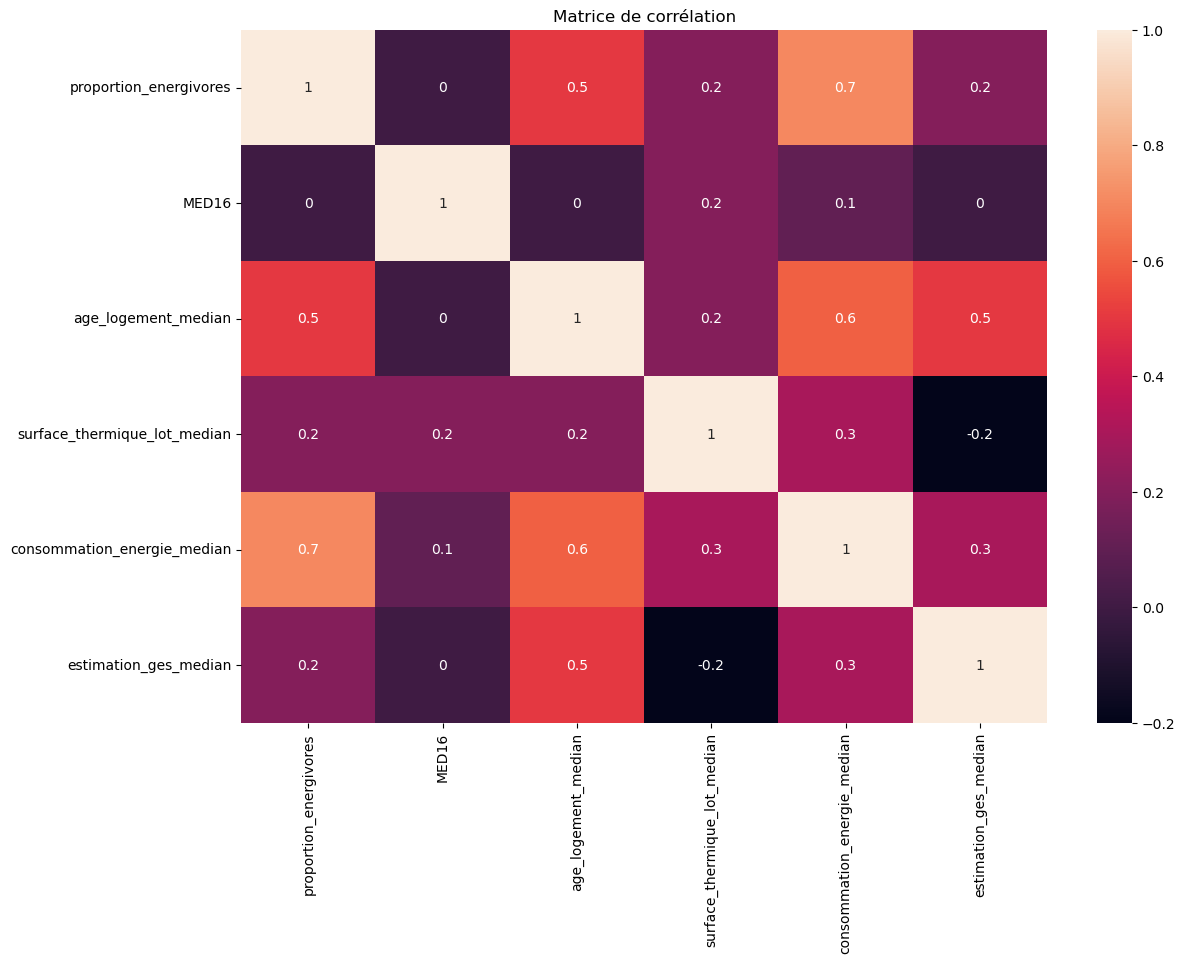

In [21]:

matrice_corr = Filosofi_dpe_IDF_com2[["proportion_energivores", "MED16" , "age_logement_median","surface_thermique_lot_median", "consommation_energie_median", "estimation_ges_median"]].corr(method='spearman').round(1)
f, ax = plt.subplots(figsize=(13, 9))
sns.heatmap(data=matrice_corr, annot=True, center=None)
plt.title("Matrice de corrélation")

Les corrélations positives entre variables les plus élevées:
    - **la proportion de logements énergivores dans la commune et la consommation d'énergie médiane dans la commune (corrélation de Pearson à 0,7).** Cela semble raisonnable, car quasi tautologique (le critère de la consommation d'énergie rentrant directement dans l'algorithme de détermination de l'attribution de la classe de consommation énergétique d'un logement).
    - **la consommation d'énergie médiane d'une commune et l'âge médian de ses logements (corrélation de Pearson à 0,6).** Ceci semble attendu: plus un logement est ancien, plus il va consommer de l'énergie.
    - **la proportion de logements énergivores dans la commune et l'âge médian de ses logements (corrélation de Pearson à 0,5).** Plus une commune présente une proportion élevée de logements diagnostiqués énergivores, plus l'âge médian de ces logements diagnostiqués est élevé.
    -**l'estimation médiane d'émission de GES des logements d'une commune et leur âge médian (corrélation de Pearson à 0,5).** L'empreinte carbonne des logements augmente avec leur âge.
    
En revanche, **on observe l'absence de corrélation entre le niveau de vie médian d'une commune et la proportion de logements énergivores**. 

Cela rejoint ce que l'on a pu constaté dans les figures précédentes. Il restera à voir si cela ne cache pas une relation non linéaire entre niveau de vie et performance énergétique des logemets, ou bien s'il n'y a pas malgré tout une corrélation partielle entre niveau de vie et performance énergétique des logements à l'échelle communale, une fois que l'on a pris en compte les autres variables explicatives. 

##### b) Nuages de points au niveau communal: proportions de logements énergivores et niveau de vie médian

Text(0.5, 1.0, "Poids des logements énergivores dans les communes d'Ile-de-France en fonction de leur niveau de vie médian")

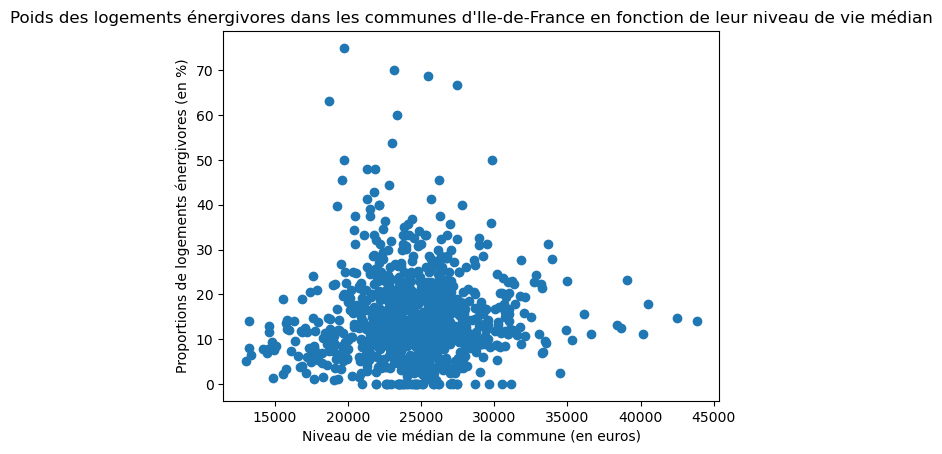

In [22]:
# Nuage de points: niveau de vie médian de la commune vs proportion de logements énergivores (classes F ou G)
plt.figure()
plt.scatter(Filosofi_dpe_IDF_com2["MED16"],Filosofi_dpe_IDF_com2["proportion_energivores_pct"])
plt.xlabel("Niveau de vie médian de la commune (en euros)")
plt.ylabel("Proportions de logements énergivores (en %)")
plt.title("Poids des logements énergivores dans les communes d'Ile-de-France en fonction de leur niveau de vie médian")

Au niveau de l'ensemble des communes d'Ile-de-France, il ne ressort pas de relation linéaire évidente entre la proportion de logements énergivores dans la commune et son niveau de vie médian.

<Figure size 640x480 with 0 Axes>

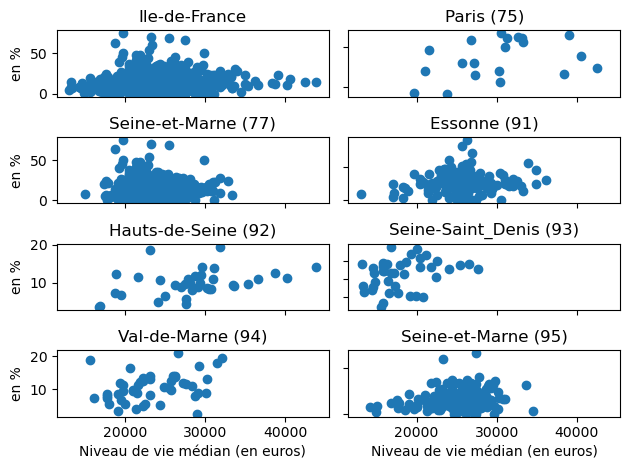

In [23]:
#import numpy as np
#import matplotlib.pyplot as plt

# Fixing random state for reproducibility
#np.random.seed(19680801)

#x = np.random.rand(10)
#y = np.random.rand(10)
#z = np.sqrt(x**2 + y**2)

Filosofi_DPE_75=Filosofi_dpe_IDF_com2[Filosofi_dpe_IDF_com2["DEP"]==75]
Filosofi_DPE_77=Filosofi_dpe_IDF_com2[Filosofi_dpe_IDF_com2["DEP"]==77]
Filosofi_DPE_91=Filosofi_dpe_IDF_com2[Filosofi_dpe_IDF_com2["DEP"]==91]
Filosofi_DPE_92=Filosofi_dpe_IDF_com2[Filosofi_dpe_IDF_com2["DEP"]==92]
Filosofi_DPE_93=Filosofi_dpe_IDF_com2[Filosofi_dpe_IDF_com2["DEP"]==93]
Filosofi_DPE_94=Filosofi_dpe_IDF_com2[Filosofi_dpe_IDF_com2["DEP"]==94]
Filosofi_DPE_95=Filosofi_dpe_IDF_com2[Filosofi_dpe_IDF_com2["DEP"]==95]

Filosofi_DPE_75

plt.figure()

fig, axs = plt.subplots(4,2, sharex=True, sharey=False)

# Ile-de-France:
axs[0, 0].scatter(Filosofi_dpe_IDF_com2["MED16"],Filosofi_dpe_IDF_com2["proportion_energivores_pct"])
axs[0, 0].set_title("Ile-de-France")

# Paris (75):
axs[0, 1].scatter(Filosofi_DPE_75["MED16"],Filosofi_DPE_75["proportion_energivores_pct"])
axs[0, 1].set_title("Paris (75)")

# Seine-et-Marne (77):
axs[1, 0].scatter(Filosofi_DPE_77["MED16"],Filosofi_DPE_77["proportion_energivores_pct"])
axs[1, 0].set_title("Seine-et-Marne (77)")

# Essonne (91):
axs[1, 1].scatter(Filosofi_DPE_91["MED16"],Filosofi_DPE_91["proportion_energivores_pct"])
axs[1, 1].set_title("Essonne (91)")

# Hauts-de-Seine (92):
axs[2, 0].scatter(Filosofi_DPE_92["MED16"],Filosofi_DPE_92["proportion_energivores_pct"])
axs[2, 0].set_title("Hauts-de-Seine (92)")

# Seine-Saint-Denis (93):
axs[2, 1].scatter(Filosofi_DPE_93["MED16"],Filosofi_DPE_93["proportion_energivores_pct"])
axs[2, 1].set_title("Seine-Saint_Denis (93)")

# Val-de-Marne (94):
axs[3, 0].scatter(Filosofi_DPE_94["MED16"],Filosofi_DPE_94["proportion_energivores_pct"])
axs[3, 0].set_title("Val-de-Marne (94)")

# Seine-et-Marne (95):
axs[3, 1].scatter(Filosofi_DPE_95["MED16"],Filosofi_DPE_95["proportion_energivores_pct"])
axs[3, 1].set_title("Seine-et-Marne (95)")

for ax in axs.flat:
    ax.set(xlabel='Niveau de vie médian (en euros)', ylabel='en %')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

plt.tight_layout()
#plt.show()

On a décliné le nuage de point par départements pour vérifier que l'absence de relation linéaire entre proportion de logements énergivores et niveau de vie se vérifie bien dans chaque département d'Ile-de-France. Effectivement, on  n'observe pas de relation linéaire évidente, à l'exception peut-être du département 92.

##### c) Quelles sont les communes défavorisées avec une proportion élévée de logements énergivores?

In [24]:
#on regarde quelles sont les communes défavorisées avec plus de 20% de logements énergivores:
filtre=(Filosofi_dpe_IDF_com2["MED16_quintiles"].isin (["Q1","Q2"]))&(Filosofi_dpe_IDF_com2["proportion_energivores_pct"]>20)
communes_energivores_pauvres=Filosofi_dpe_IDF_com2[filtre]
communes_energivores_pauvres.sort_values(by="NBMENFISC16",ascending=False).head(20)

,index,CODGEO,LIBGEO,NBMENFISC16,NBPERSMENFISC16,MED16,DEP,MED16_quintiles,code_insee_commune_actualise,consommation_energie,...,surface_thermique_lot_median,age_logement_median,consommation_energie_median,estimation_ges_median,nombre_dpe,ratio_DPE_menage,proportion_energivores,com_prop_energivores,classe_taille_com,proportion_energivores_pct
636,949,91589,Savigny-sur-Orge,14914.0,37122.5,24012.666667,91,Q2,91589.0,249.748411,...,68.220,43.0,242.000,31.480,4915.0,0.329556,0.210376,Plus de 20%,Plus de 10 000 hab.,21.037640
590,901,91421,Montgeron,9318.0,23497.5,23356.000000,91,Q2,91421.0,258.284147,...,75.000,44.0,249.340,34.800,2023.0,0.217107,0.209095,Plus de 20%,Plus de 10 000 hab.,20.909540
282,304,77296,Moissy-Cramayel,6155.0,17664.0,20508.000000,77,Q1,77296.0,235.832352,...,60.000,17.0,225.740,16.500,1029.0,0.167181,0.375121,Plus de 20%,Plus de 10 000 hab.,37.512148
346,380,77379,Provins,5222.0,11523.0,17595.000000,77,Q1,77379.0,271.675747,...,74.000,39.0,268.760,16.000,395.0,0.075642,0.240506,Plus de 20%,Plus de 10 000 hab.,24.050633
796,1110,95019,Arnouville,4797.0,14342.0,18983.333333,95,Q1,95019.0,278.276775,...,74.285,66.0,260.000,39.110,1656.0,0.345216,0.219807,Plus de 20%,Plus de 10 000 hab.,21.980676
892,1213,95394,Méry-sur-Oise,3475.0,9735.5,23943.809524,95,Q2,95394.0,275.120813,...,79.100,46.0,173.000,15.810,1390.0,0.400000,0.228058,Plus de 20%,Entre 200 et 10 000 hab.,22.805755
205,223,77215,Gretz-Armainvilliers,3276.0,8524.0,21867.878788,77,Q1,77215.0,306.144676,...,71.000,39.0,319.830,49.340,834.0,0.254579,0.480815,Plus de 20%,Entre 200 et 10 000 hab.,48.081535
606,917,91479,Paray-Vieille-Poste,3052.0,7532.5,23994.000000,91,Q2,91479.0,268.557013,...,64.390,39.0,264.400,20.000,673.0,0.220511,0.301634,Plus de 20%,Entre 200 et 10 000 hab.,30.163447
818,1132,95091,Bouffémont,2132.0,5991.5,23841.333333,95,Q2,95091.0,226.477158,...,73.900,27.0,245.750,14.300,739.0,0.346623,0.217862,Plus de 20%,Entre 200 et 10 000 hab.,21.786198
175,192,77182,La Ferté-Gaucher,1969.0,4559.0,17400.000000,77,Q1,77182.0,237.717423,...,79.190,24.0,239.000,12.650,291.0,0.147791,0.206186,Plus de 20%,Entre 200 et 10 000 hab.,20.618557


On comptabilise 108 communes d'Ile-de-France qui se situent dans les deux premiers quintiles de niveau de vie et qui présentent une proportion de logements énergivores supérieure à 20%. Ci-dessus, la liste des 20 communes les plus grandes (en nombre d'habitants).

Dans le contexte de la crise énergétique actuelle, ces communes pourraient présenter un risque de vulnérabilité sociale accrue, du fait qu'elles rassemblent une proportion importante de ménages avec à la fois une contrainte budgétaire forte (faible niveau de vie en euros) et une performance énergétique des logements plus faible, ce qui induit un renchérissement plus marqué de la facture énergétique pour ces communes. Un travail d'approfondissement de cette question pourrait consister à décrire à une maille géographique plus fine (données carroyées de l'Insee par exemple) ces zones de vulnérabilité "socio-énergétique". Mais un tel raffinement exigerait de disposer de suffisamment de dpe à ces niveaux géographiques plus fins, ce qui n'est pas garanti.

### **B) Un peu de cartographie...**

#### 1) Cartes statiques:

In [ ]:
# On exécute le notebook appelé ci-dessous qui prépare les données nécessaires et génèrent deux cartes statiques:
# 1. une première carte sur les niveaux de vie médian par commune d'Ile-de-France
# 2. une deuxième carte sur les proportions de logements énergivores par commune d'Ile-de-France
# 3. une troisième carte sur les niveaux de vie médian par arrondissement de Paris
# 4. une quatrième carte sur les proportions de logements énergivores par arrondissement de Paris
%run "~/work/data_science_project/Création_cartes_statiques.ipynb"

Principaux messages à retenir:
 1. Tout d'abord, on remarque bien ici l'absence du département des Yvelines sur les deux premières cartes. Cela était attendu, dans la mesure où l'on ne dispose pas de classe de consommation énergétique renseignée pour les logements diagnistiqués dans ce département.
2. Sur la première carte, on retrouve bien ce que l'on attendait, à savoir; les départements du nord parisien qui concentrent le plus de ménages à faible niveau de vie, tandis qu'à l'ouest, le 92 et le 91 concentrent les ménages les plus aisés. Des situations plus intermédiaires en termes de niveau de vie sont relevées dans les départements à l'est, notamment dans le 77.
3. Sur la carte 2, il apparaît que les communes dans les départements de la petite couronne proches de Paris affichent une faible proportion de logements énergivores, comme si le caractère très urbanisé de ces territoires avec une prédominance d'appartements contribuait à garantir une certaine performance énergétique. Puis plus on s'éloigne de la petite couronne, et en particulier à l'est, plus les logements énergivores ont nombreux dans les communes. Le caractère plus rural de ces communes avec une prédominance de maisons pourrait expliquer en partie ce phénomène.
4. Sur la carte 3, on observe des variations de niveau de vie assez nettes entre arrondissements parisiens, avec un ouest et centre parisien très aisé et un nord est parisien plus défavorisé. Naturellement, on ne capte pas ici toute l'hétérogénéité qui existe au sein même de certains de ces arrondissements, à l'instar du XVIIIème par exemple.
5. Sur la carte 4, on remarque un coeur parisien (arrondissements I à VIII) qui se distingue par son niveau élevé de logements énergivores, et qui contraste avec les arrondissements plus périphériques qui ont une proportion de logements énergivores moins élevés. Mis en regard avec la carte 3, on observe ainsi que les quartiers les plus aisés du coeur parisien concentrent le plus de logements énergivores, ce qui pourrait être le reflet du développement historique du bâtit parisien, avec une prédominance de grands immeubles haussmaniens du XIXème siècles beaucoup plus énergivores que les immeubles récents du fait de leur vétusté. Paris semble donc assez atypique et aller contre la logique microéconomique standard: un ménage avec une contrainte budgétaire plus forte serait davantage exposé aux problèmes de performance énergétique des logements, ces derniers ne pouvant financer l'achat d'appartements bien isolés ou réaliser les travaux nécessaires pour que ce soit le cas.

### 2) Cartes interactives:

In [ ]:
%run "~/work/data_science_project/Création_cartes_interactives.ipynb"

In [ ]:
# Sortie de la carte
carte_fin

*Note:*  Un code de couleur précis est  adopté pour chaque couche. Ainsi:
1. Sur la première couche, les communes les plus riches se trouvent en zone rosatres, ou orangées.
2. Sur la seconde, plus le vert est foncé moins la commune comporte des logements énergivores.

#### Principal message à retenir:

 Comme l'indiquait déjà la statistique descriptive, le niveau de vie ne semble pas influencer le degré de performance énergétique dans les communes Franciliennes.
 
 Afin d'en avoir le coeur net, nous réalisons une modélisation avec d'autres variables jugées pertinentes pour expliquer la consommation d'énergie des logements.

## **II) Modélisation: prédiction de la proportion de logements énergivores des communes d'Ile-de-France**

### 1) D'abord, une analyse par composante principale (ACP) pour y voir un peu plus clair en ce qui concerne les variables pertinentes...

In [ ]:
# On commence par faire une ACP

# Etape 0 : choix des variables
Filosofi_dpe_IDF_com1=Filosofi_dpe_IDF_com.dropna()
variable=['nombre_dpe','surface_thermique_lot_median','age_logement_median','NBPERSMENFISC16','classe_age_Neuf (<5ans)'
         ,'classe_age_Entre 50 et 100 ans','classe_age_Récent (entre 5 et 10 ans)','classe_age_Entre 10 et 25 ans',
          "classe_age_Entre 25 et 50 ans","classe_age_Plus de 100 ans","MED16","surface_thermique_lot_median"]

use_dpe=Filosofi_dpe_IDF_com1[variable]
use_dpe.head()

In [ ]:
# Standardisation 
scaler = StandardScaler()
scaler.fit(use_dpe)

In [ ]:
use_dpe.head()

In [ ]:
sc_dpe =pd.DataFrame(data=scaler.transform(use_dpe),index=Filosofi_dpe_IDF_com1["CODGEO"],columns=variable)

In [ ]:
# Choix du nombre de composantes

pca = PCA().fit(sc_dpe)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Nombre de composantes')
plt.ylabel('Variance cumulative expliquée')

**On choisit d'implémenter avec 5 composantes principales qui contiennent de 85% de l'inertie total**

In [ ]:
pca=PCA(n_components=5)

In [ ]:
pca.fit(sc_dpe)

In [ ]:
x_pca=pca.transform(sc_dpe)

In [ ]:
x_pca.shape

In [ ]:
# On choisir la couleur comme la proportion des logement énervore E,F et G
energivore=Filosofi_dpe_IDF_com1["classe_consommation_energie_G"]+Filosofi_dpe_IDF_com1["classe_consommation_energie_F"]+Filosofi_dpe_IDF_com1["classe_consommation_energie_E"]

In [ ]:
result=pd.DataFrame(x_pca,columns=['PCA%i' % i for i in range(5)],index=use_dpe.index)
result["energivore"]=energivore
result["consommation_energie_median"]=Filosofi_dpe_IDF_com1["consommation_energie_median"]
result.head()

In [ ]:
for i in list(result.columns):
    result=result[(result[i]!= max(result[i]))]   
result.info()

In [ ]:
#Plot initialisation
#fig = plt.figure(figsize=(10,10))
#ax = fig.add_subplot(111, projection='3d')
#ax.scatter(result['PCA0'], result['PCA1'], result['PCA2'], c=result["energivore"], cmap="Set2_r", s=30)

# make simple, bare axis lines through space:
#xAxisLine = ((min(result['PCA0']), max(result['PCA0'])), (0, 0), (0,0))
#ax.plot(xAxisLine[0], xAxisLine[1], xAxisLine[2], 'r')
#yAxisLine = ((0, 0), (min(result['PCA1']), max(result['PCA1'])), (0,0))
#ax.plot(yAxisLine[0], yAxisLine[1], yAxisLine[2], 'r')
#zAxisLine = ((0, 0), (0,0), (min(result['PCA2']), max(result['PCA2'])))
#ax.plot(zAxisLine[0], zAxisLine[1], zAxisLine[2], 'r')

# label the axes
#ax.set_xlabel("PC1")
#ax.set_ylabel("PC2")
#ax.set_zlabel("PC3")
#ax.set_title("PCA")
#plt.show()'''

In [ ]:
# Provoir explicatif du model
print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.sum())

In [ ]:
# Observation des ressembles sur les axes factorielles en fonction de la proportion
# de logements energivores

fig=plt.figure(figsize=(9,9))
plt.subplot(2,2,1)
plt.scatter(result["PCA0"],result["PCA0"], c=result['energivore'] , cmap = 'plasma')
plt.xlabel('Comp 1')
plt.ylabel('Comp 1')
plt.colorbar(label="proportion de logements energivores")

plt.subplot(2,2,2)
plt.scatter(result["PCA0"],result["PCA1"], c=result['energivore'] , cmap = 'plasma')
plt.xlabel('Comp 1')
plt.ylabel('Comp 2')
plt.colorbar(label="proportion de logements energivores")

plt.subplot(2,2,3)
plt.scatter(result["PCA1"],result["PCA0"], c=result['energivore'] , cmap = 'plasma')
plt.xlabel('Comp 2')
plt.ylabel('Comp 1')
plt.colorbar(label="proportion de logements energivores")

plt.subplot(2,2,4)
plt.scatter(result["PCA1"],result["PCA1"], c=result['energivore'] , cmap = 'plasma')
plt.xlabel('Comp 2')
plt.ylabel('Comp 2')
plt.colorbar(label="proportion de logements energivores")

**Ceci nous donne une première apercue sur l'idée selon laquelle les caractéristiques des logements et le niveau
de revenu pourons expliquer la proportion des logements energivore dans une commune (Les deux premiers axes representent près de 50% de l'inertie total **

Pour appréhender cette idée, nous representons les premiers axes factorials

In [ ]:
# Représentation dynamique en 3D  des axes factorielles en fonction de la proportion
# de logements energivores
#components = pca.fit_transform(sc_dpe)
var = pca.explained_variance_ratio_.sum() # variance expliquée
# Plot de la figure
fig = px.scatter_3d(data_frame=result[['PCA0','PCA1','PCA2']], x = 'PCA0', y='PCA1', z='PCA2',
                   color=result['energivore'],width=900,height=900)
fig.add_annotation()
fig.show()

In [ ]:

# Observation des ressembles sur les axes factorielles en fonction de la consommmation d'énergie médian

fig=plt.figure(figsize=(9,9))
plt.subplot(2,2,1)
plt.scatter(result["PCA0"],result["PCA0"], c=result['consommation_energie_median'] , cmap = 'plasma')
plt.xlabel('Comp 1')
plt.ylabel('Comp 1')
plt.colorbar(label="consommation energie mediane")

plt.subplot(2,2,2)
plt.scatter(result["PCA0"],result["PCA1"], c=result['consommation_energie_median'] , cmap = 'plasma')
plt.xlabel('Comp 1')
plt.ylabel('Comp 2')
plt.colorbar(label="consommation energie mediane")

plt.subplot(2,2,3)
plt.scatter(result["PCA1"],result["PCA0"], c=result['consommation_energie_median'] , cmap = 'plasma')
plt.xlabel('Comp 2')
plt.ylabel('Comp 1')
plt.colorbar(label="consommation energie mediane")

plt.subplot(2,2,4)
plt.scatter(result["PCA1"],result["PCA1"], c=result['consommation_energie_median'] , cmap = 'plasma')
plt.xlabel('Comp 2')
plt.ylabel('Comp 2')
plt.colorbar(label="consommation energie mediane")

In [ ]:
# Représentation dynamique en 3D  des axes factorielles en fonction de le consommation d'energie median
var = pca.explained_variance_ratio_.sum() # variance expliquée
# Plot de la figure
fig = px.scatter_3d(data_frame=result[['PCA0','PCA1','PCA2']], x = 'PCA0', y='PCA1', z='PCA2',
                   color=result['consommation_energie_median'],width=900,height=900)
fig.add_annotation()
fig.show()

**L'analyse factorielle précédente conforte l'hypothèse selon laquelle les caractéristiques des batiments telles que l'age, la surface thermique, le revevenu médian dans la commune etc... pouront bien expliquer la proportion des logements énergivores ainsi que le niveau de consommmation d' energie dans une commune.**

Dans la suite, nous implémentons une régression Lasso. Celle-ci nous permettra non seulement de prédire ces deux variables (consommmation d' energie median et proportion des logements énergivores), mais égalemant de selectionner les variables les plus pertinentes pour une telle prédiction.

### 2) Implémentation d'une régression Lasso pour prédire au mieux la proportion de logements énergivores dans une commune d'Ile-de-France

In [ ]:
# Variables potientielles
variable=['nombre_dpe','age_logement_median','NBPERSMENFISC16','classe_age_Neuf (<5ans)'
         ,'classe_age_Entre 50 et 100 ans','classe_age_Récent (entre 5 et 10 ans)','classe_age_Entre 10 et 25 ans',
          "classe_age_Entre 25 et 50 ans","MED16","surface_thermique_lot_median",
          "classe_surface_Moins de 30 m2","classe_surface_Entre 30 et 60 m2","classe_surface_Entre 60 et 100 m2",'classe_surface_Plus de 100 m2']

In [ ]:
X=Filosofi_dpe_IDF_com1[variable]
y=Filosofi_dpe_IDF_com1['classe_consommation_energie_E']+Filosofi_dpe_IDF_com1['classe_consommation_energie_F']+Filosofi_dpe_IDF_com1['classe_consommation_energie_G']

In [ ]:
# Echantillon d'apprentissage et echantillon de test 70% et 30% respectivement
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

In [ ]:
# Standartissation des variables pour éviter les effets de taille et d'échèlle
scaler = StandardScaler().fit(X_train[variable])
X_train[variable] = scaler.transform(X_train[variable])
X_test[variable] = scaler.transform(X_test[variable])

#### a) Choix du alpha optimal:

In [ ]:
# Lasso with 20 fold cross-validation
model = LassoCV(cv=20, random_state=0, max_iter=10000)

In [ ]:
# Fit model
model.fit(X_train, y_train)

In [ ]:
LassoCV(cv=20, max_iter=10000, random_state=0)

In [ ]:
model.alpha_

In [ ]:
# Set best alpha
lasso_best = Lasso(alpha=model.alpha_)
lasso_best.fit(X_train, y_train)

In [ ]:
Lasso(alpha=model.alpha_)

#### b) Coefficients estimés du modèle retenu

In [ ]:
#Show model coefficients and names:

print(list(zip(lasso_best.coef_, X)))

Il resort que les variables telles que la  proportion des batiments agés entre 50 et 100 ans ('classe_age_Entre 50 et 100 ans'), la  proportion des batiments agés entre 10 et 25 ans (classe_age_Entre 10 et 25 ans), entre 25 et 50 ans ('classe_age_Entre 25 et 50 ans') contribuent à la hausse de la proportion des batiments énergivore. Par contre la  proportion des batiments recents (classe_age_Récent (entre 5 et 10 ans)) contribue à la baisse du niveau de cette proportion. 

In [ ]:
print('R squared training set', round(lasso_best.score(X_train, y_train)*100, 2))
print('R squared test set', round(lasso_best.score(X_test, y_test)*100, 2))

In [ ]:
mean_squared_error(y_test, lasso_best.predict(X_test))

In [ ]:
plt.semilogx(model.alphas_, model.mse_path_, ":")
plt.plot(
    model.alphas_ ,
    model.mse_path_.mean(axis=-1),
    "k",
    label="Average across the folds",
    linewidth=2,
)
plt.axvline(
    model.alpha_, linestyle="--", color="k", label="alpha: CV estimate"
)

plt.legend()
plt.xlabel("alphas")
plt.ylabel("Mean square error")
plt.title("Mean square error on each fold")
plt.axis("tight")

### 3) Variante de modélisation: implémentation d'une régression Lasso pour prédire au mieux la consommation d'énergie médiane des logements dans une commune d'Ile-de-France

In [ ]:
X=Filosofi_dpe_IDF_com1[variable]
y=Filosofi_dpe_IDF_com1['consommation_energie_median']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

In [ ]:
scaler = StandardScaler().fit(X_train[variable])
X_train[variable] = scaler.transform(X_train[variable])
X_test[variable] = scaler.transform(X_test[variable])

#### a) Choix du alpha optimal:

In [ ]:
# Lasso with 5 fold cross-validation
model = LassoCV(cv=20, random_state=0, max_iter=10000)

In [ ]:
# Fit model
model.fit(X_train, y_train)

In [ ]:
LassoCV(cv=20, max_iter=10000, random_state=0)

In [ ]:
model.alpha_

In [ ]:
# Set best alpha
lasso_best = Lasso(alpha=model.alpha_)
lasso_best.fit(X_train, y_train)

In [ ]:
Lasso(alpha=model.alpha_)

#### b) Coefficients estimés du modèle retenu

In [ ]:
#Show model coefficients and names:

print(list(zip(lasso_best.coef_, X)))

**On obtient les mêmes conclusions que celles de la modélisation précédante**

In [ ]:
print('R squared training set', round(lasso_best.score(X_train, y_train)*100, 2))
print('R squared test set', round(lasso_best.score(X_test, y_test)*100, 2))

In [ ]:
mean_squared_error(y_test, lasso_best.predict(X_test))

In [ ]:
plt.semilogx(model.alphas_, model.mse_path_, ":")
plt.plot(
    model.alphas_ ,
    model.mse_path_.mean(axis=-1),
    "k",
    label="Average across the folds",
    linewidth=2,
)
plt.axvline(
    model.alpha_, linestyle="--", color="k", label="alpha: CV estimate"
)

plt.legend()
plt.xlabel("alphas")
plt.ylabel("Mean square error")
plt.title("Mean square error on each fold")
plt.axis("tight")